In [1]:
from taqsim.node import Source, Sink, Storage
from taqsim.edge import Edge
from taqsim.node.timeseries import TimeSeries
from taqsim.system import WaterSystem
from taqsim.common import Strategy
from dataclasses import dataclass
from typing import ClassVar

In [ ]:
@dataclass(frozen=True)
class FixedRelease(Strategy):
    __params__: ClassVar[tuple[str, ...]] = ("rate",) 
    rate: float = 50.0

    def release(self, storage, dead_storage, capacity, inflow, t, dt):
        available = storage - dead_storage
        return min(self.rate * dt, available)

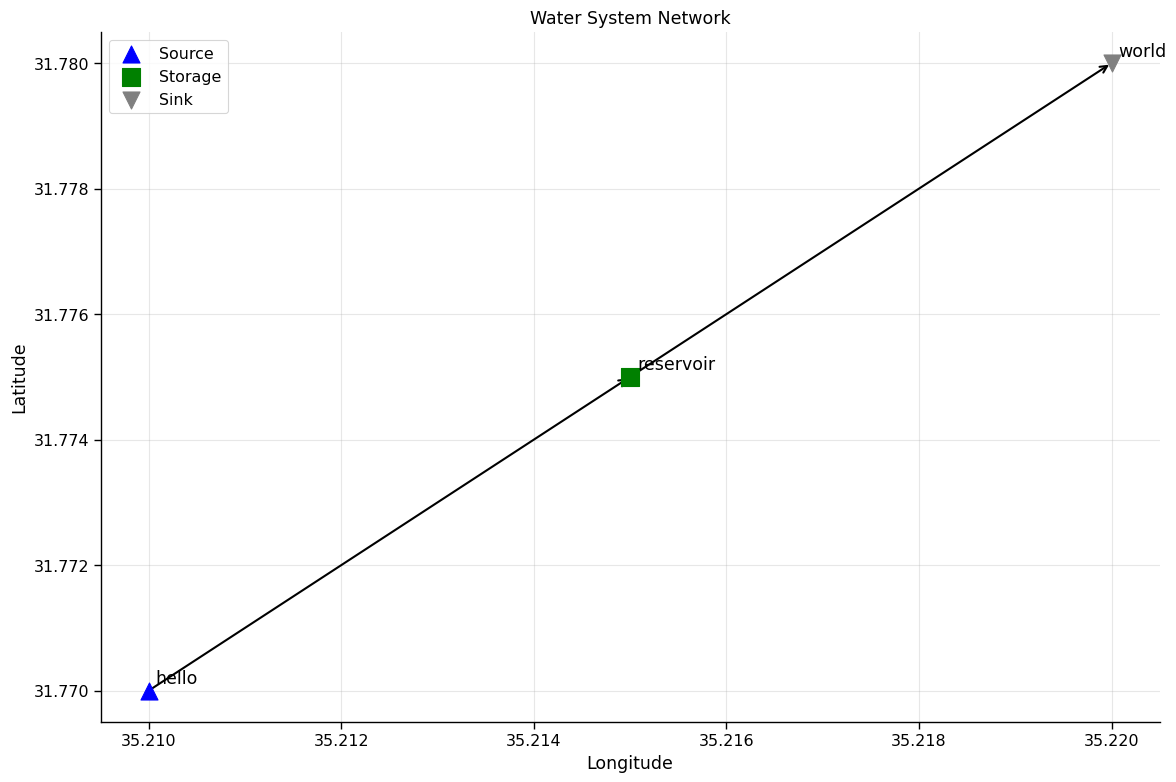

In [4]:
class NoLoss:
    def calculate(self, flow, capacity, t, dt):
        return {}

system = WaterSystem()
system.add_node(Source(id="hello", inflow=TimeSeries([100]*12), location=(31.77, 35.21)))
system.add_node(Storage(id="reservoir", capacity=500, release_rule=FixedRelease(rate=80.0), location=(31.775, 35.215), loss_rule=NoLoss()))
system.add_node(Sink(id="world", location=(31.78, 35.22)))
system.add_edge(Edge(id="e", source="hello", target="reservoir", capacity=100, loss_rule=NoLoss()))
system.add_edge(Edge(id="e2", source="reservoir", target="world", capacity=100, loss_rule=NoLoss()))
system.validate()

system.visualize()

In [5]:
system.param_schema()

[ParamSpec(path='reservoir.release_rule.rate', value=80.0, index=None)]